# Importing required libraries

In [2]:
%run ./EODHD_Functions.ipynb
%run ./Option_Pricing_Models.ipynb
import requests
import pandas as pd
import datetime as dt
import numpy as np
import os as os
from textblob import TextBlob
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
import matplotlib.pyplot as mdates
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
import numpy as np

# Using option pricing models to price a call option

         date  adjusted_close
0  2024-06-17         13.3649
1  2024-06-18         12.7951
2  2024-06-19         12.8042
3  2024-06-20         12.7629
4  2024-06-21         12.6572


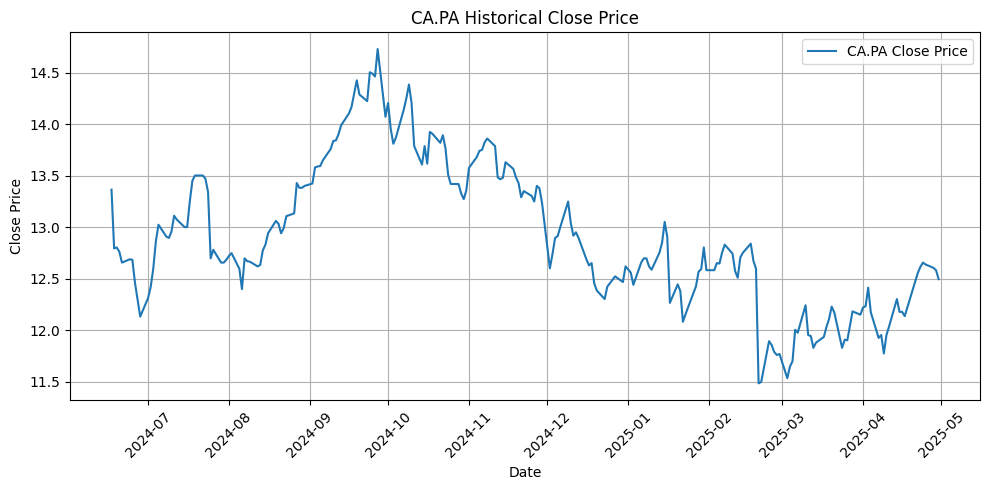

In [ ]:
# Fitting existing data with jump diffusion model
Function = EODHD_Functions()
start_date = "2024-06-15"
end_date = "2025-05-01"

CA = Function.Fetch_historical_price("CA.PA", start_date, end_date, "d")


# Convert 'date' column to datetime if not already
CA['date'] = pd.to_datetime(CA['date'])

# Plot the historical price data with correct year-month labels on x-axis
plt.figure(figsize=(10, 5))
plt.plot(CA['date'], CA['adjusted_close'], label='CA.PA Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('CA.PA Historical Close Price')
plt.legend()
plt.grid(True)

# Format x-axis to show year-month (YYYY-MM)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [ ]:
Fit_model = simulate_jump_diffusion(S0, mu, sigma, lamb, mu_j, sigma_j, T, N)

S0 = s['adjusted_close'].iloc[-1]  # initial stock price as a float
mu = 0.05      # expected return
sigma = Calculate_volatility(CA,days)   # volatility
lamb = 0.75   # average number of jumps per year
mu_j = -0.2   # mean of jump size (in log)
sigma_j = 0.1 # std dev of jump size (in log)
T = (end_date-start_date)/252         # time horizon (years)
N = (end_date-start_date)       # number of steps (daily)